<center> </center>

<center><font size=5 face="Helvetica" color=#306998><b>
Meep Tutorial: A Straight Waveguide
</b></font></center>

<center><font face="Helvetica" size=3><b>Ang Chen</b></font></center>
<center><font face="Helvetica" size=3>December, 2024</font></center>

***

For our first example, let's examine the field pattern excited by a localized continuous wave (CW) source in a waveguide — first straight, then bent. The waveguide will have frequency-independent $\epsilon$=12 and width 1 $\mu\text{m}$. The unit length in this example is 1 $\mu\text{m}$.

The first thing to do always is to load the Meep library, along with any other library we may need for post processing or visualization:

In [1]:
from IPython.display import Video
import matplotlib.pyplot as plt
import meep as mp

plt.rcParams["font.family"] = "Helvetica"
%matplotlib inline
%config InlineBackend.figure_format='svg'

Using MPI version 3.1, 1 processes


# Simulation Domain

We can begin specifying each of the simulation objects starting with the computational cell. 

We're going to put a source at one end and watch the fields propagate down the waveguide in the $x$ direction, so let's use a cell of length 16 $\mu\text{m}$ in the $x$ direction to give it some distance to propagate. In the $y$ direction, we just need enough room so that the boundaries do not affect the waveguide mode; let's give it a size of 8 $\mu\text{m}$.

In [2]:
cell = mp.Vector3(16, 8, 0)

The `Vector3` object stores the size of the cell in each of the three coordinate directions. This is a 2d cell in $x$ and $y$ where the $z$ direction has size 0. All 2D simulations must lie in the XY plane, as we've specified.

# Geometry

Next we add the waveguide. Most commonly, the device structure is specified by a set of `GeometricObjects` stored in the `geometry` object.

In [3]:
geometry = [
    mp.Block(
        mp.Vector3(mp.inf, 1, mp.inf),
        center=mp.Vector3(),
        material=mp.Medium(epsilon=12),
    )
]

The waveguide is specified by a Block (parallelepiped) of size $\infty \times 1 \times \infty$, with $\epsilon$=12, centered at (0,0) which is the center of the cell. By default, any place where there are no objects there is air ($\epsilon$=1), although this can be changed by setting the `default_material` variable (shown below).

# Sources

We have the structure and need to specify the current sources using the `sources` object. The simplest thing is to add a single point source $J_z$:

In [4]:
sources = [
    mp.Source(
        mp.ContinuousSource(frequency=0.15), component=mp.Ez, center=mp.Vector3(-7, 0)
    )
]

We gave the source a frequency of 0.15, and specified a `ContinuousSource` which is just a fixed-frequency sinusoid exp($−i\omega t$) that by default is turned on at $t=0$. 

Recall that, in Meep units, frequency is specified in units of $2\pi c$, which is equivalent to the inverse of the vacuum wavelength. Thus, 0.15 corresponds to a vacuum wavelength of about 1/0.15=6.67 μm, or a wavelength of about 2 μm in the ε=12 material — thus, our waveguide is half a wavelength wide, which should hopefully make it single mode. In fact, the cutoff for single-mode behavior in this waveguide is analytically solvable, and corresponds to a frequency of $\frac{1}{2\sqrt{11}}$ or roughly 0.15076. 

Note also that to specify a $J_z$, we specify a component `Ez` (e.g., if we wanted a magnetic current, we would specify `Hx`, `Hy`, or `Hz`). 

The current is located at (-7,0), which is 1 $\mu$m to the right of the left edge of the cell — we always want to leave a little space between sources and the cell boundaries, to keep the boundary conditions from interfering with them.

# Boundary layers

As for boundary conditions, we want to add absorbing boundaries around our cell. 

Absorbing boundaries in Meep are handled by perfectly matched layers (PML) — which aren't really a boundary condition at all, but rather a fictitious absorbing material added around the edges of the cell. To add an absorbing layer of thickness 1 $\mu$m around all sides of the cell, we do:

In [5]:
pml_layers = [mp.PML(thickness=1.0)]

# pml_layers = [mp.PML(thickness=1.0,direction=mp.X,side=mp.High)]


`pml_layers` is a `list` of `PML` objects — you may have more than one `PML` object if you want `PML` layers only on certain sides of the cell. For example, `mp.PML(thickness=1.0,direction=mp.X,side=mp.High)` specifies a `PML` layer on only the `+x` side. 

An important point: the PML layer is inside the cell, overlapping whatever objects you have there. So, in this case our PML overlaps our waveguide, which is what we want so that it will properly absorb waveguide modes. 

The finite thickness of the PML is important to reduce numerical reflections.

# Resolution

Meep will discretize this structure in space and time, and that is specified by a single variable, `resolution`, that gives the number of pixels per distance unit. 

We'll set this resolution to 10 pixels/$\mu\text{m}$, which corresponds to around 67 pixels/wavelength, or around 20 pixels/wavelength in the high-index material. In general, at least 8 pixels/wavelength in the highest dielectric is a good idea. This will give us a 160×80 cell.

In [6]:
resolution = 10

# Simulation object

The final object to specify is `Simulation` which is based on all the previously defined objects:

In [7]:
sim = mp.Simulation(
    cell_size=cell,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=sources,
    resolution=resolution,
)

# Visualization

Before we actually run our simulation, we often want to visualize the entire domain to ensure that the geometry, source, boundary layers, and even monitors are all correct.

We can create a figure using `matplotlib`, and pass the figure axis to the `plot2D` function. This function plots all of the relevant simulation objects in the passed axis handle. Any arbitrary slice may be specified. The default is through `z=0`.

## Plot method 1

     block, center = (0,0,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)


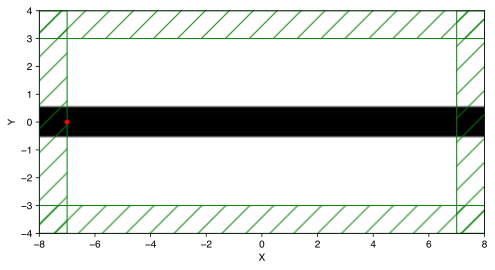

In [8]:
plt.figure(figsize=(8, 6))
sim.plot2D()
plt.show()

## Plot method 2

In [9]:
# eps_data = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Dielectric)

# fig, ax = plt.subplots(1, 1, figsize=(8, 6))
# ax.imshow(eps_data.transpose(), interpolation='spline36', cmap='binary')
# ax.axis('off')

# # fig.tight_layout()
# plt.show()

The green boxes represent the PML boundary layers. The black line through the middle is our waveguide. The red dot is our source.

Everything looks like we would expect, so let's run the simulation.

# Simulation

We are ready to run the simulation. We time step the fields until a time of 200:

In [10]:
sim.run(until=200)

-----------
Initializing structure...
time for choose_chunkdivision = 7.9e-05 s
Working in 2D dimensions.
Computational cell is 16 x 8 x 0 with resolution 10
     block, center = (0,0,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.011642 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (4000 timesteps)


It should finish in less than a second. We can analyze and visualize the fields using `plot2D`:

## Plot method 1

     block, center = (0,0,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)


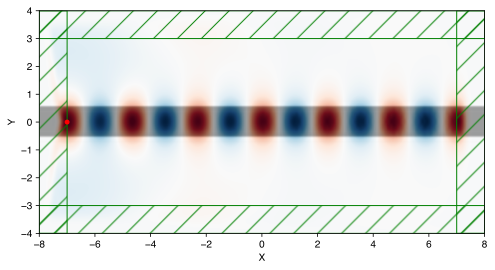

In [11]:
plt.figure(figsize=(8, 6))
sim.plot2D(fields=mp.Ez)
plt.show()
plt.close()

## Plot method 2

In [12]:
# ez_data = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Ez)

# fig, ax = plt.subplots(1, 1, figsize=(8, 6))
# plt.imshow(eps_data.transpose(), interpolation='spline36', cmap='binary')
# plt.imshow(ez_data.transpose(), interpolation='spline36', cmap='RdBu', alpha=0.9)
# ax.axis('off')

# fig.tight_layout()
# plt.show()

We can see the `Ez` component of the fields superimposed on the previous domain plot. We can choose to plot any of the six field components specified earlier.

# Animation

Often, we want to track the evolution of the fields as a function of time. This helps us ensure the fields are propogating as we would expect.

We can easily accomplish this using a `run` function. Run functions are passed to the `sim.run()` method and can be called every time step. The `Animate2D()` run function can be used to generate an animation object by grabbing frames from an arbitrary number of time steps.

We need to pass the `sim` object we created, specify which `fields` component we are interested in tracking, specify how often we want to record the fields, and whether to plot everything in real time. For this simulation, let's look at the `Ez` fields and take a snapshot every 1 time units. 

Unfortunately, Jupyter notebooks don't render realtime figure updates natively, so we'll turn this feature off and just view the animation after it runs.

We also want to restart the field propogation by calling `reset_sim()`.

In [13]:
sim.reset_meep()
f = plt.figure(dpi=100)
Animate = mp.Animate2D(fields=mp.Ez, f=f, realtime=False, normalize=True)
plt.close()

Once defined, we can pass it along with our original argument, `until`. This time, however, we'll just run until 50 time units. We'll tell meep to record the field information every 1 time unit by using the `at_every()` run function modifier.

In [14]:
sim.run(mp.at_every(1, Animate), until=100)
plt.close()

-----------
Initializing structure...
time for choose_chunkdivision = 5.3e-05 s
Working in 2D dimensions.
Computational cell is 16 x 8 x 0 with resolution 10
     block, center = (0,0,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.007201 s
-----------


FloatProgress(value=0.0, description='0% done ')

     block, center = (0,0,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
Normalizing field data...
run 1 finished at t = 100.0 (2000 timesteps)


Now that we've run the simulation, we can postprocess the animation and export it to an mp4 video using the `to_mp4()` method. We'll specify a filename and 10 frames-per-second (`fps`).

In [17]:
filename = "media/straight_waveguide.mp4"
Animate.to_mp4(10, filename)

Generating MP4...


Finally, we can use some iPython tools to visualize the animation natively.
As expected, the fields propogate down the waveguide.

In [18]:
Video(filename)